## BoomBikes Bike Sharing Assignment

#### Problem Statement:

Consider a shared bike provider company viz. BoomBikes that has a dataset containing the daily bike demands across the American market based on various meteorological conditions and people's styles factors. The firm wishes to use the data to manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the management wants to understand the demand dynamics of a new market, with the help of available data.

So, the company wants —


1. To identify the variables affecting shared bike demand.

2. To create a linear model that quantitatively relates shared bike demand with variables and hence overhaul their strategy to make suply-demand efficient.

3. To apply the prepared model in the newly discovered markets and hence understand their demand dynamics.


We have broadly divided the whole process into following steps:
1. Reading and Understanding the Data
2. Data Visualization
3. Data Preparation
4. Splitting the Data into Training and Testing Sets
5. Building a linear model
6. Residual Analysis of the train data
7. Making Predictions Using the Final Model
8. Model Evaluation

## Step 1: Reading and Understanding the Data

Let us first import useful libraries and read the dataset

In [1]:
#import useful libraries 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

import warnings    
warnings.filterwarnings('ignore')     # Supress Warnings

In [2]:
df = pd.read_csv("day.csv")

In [3]:
# Check the head of the dataset
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


Let's check the various aspects of the day dataframe.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


From the above, we know that there is no null values present in the dataset. Hence no need for *NA* value treatment.

There are two kind of data in our dataset, first kind is categorical and the other is numeric. Categorical data is encoded. So let's first map them back to their actual values for better data visualization. <br><br>
Regarding `weathersit` column, we note from the data dictionary that this column is basically indicating four weather situations i.e. 1:'Good',2:'Medium',3:'Bad', 4:'Worst'. Since this column's actual names are too long, we would get the dummy variables of this column based on the aforesaid mapping. 

In [5]:
df['season']=df.season.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
df['yr']=df.yr.map({0: '2018', 1:'2019'})
df['mnth']=df.mnth.map({1: 'Jan', 2:'Feb',3: 'Mar', 4:'Apr',5: 'May',
                        6:'Jun',7: 'Jul', 8:'Aug',9: 'Sep', 10:'Oct',11: 'Nov', 12:'Dec'})
df['holiday']=df.holiday.map({0: 'Non-Holiday', 1:'Holiday'})
df['weekday']=df.weekday.map({0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat'})
df['workingday']=df.workingday.map({0: 'Non-Workingday', 1:'Workingday'})
df['weathersit']=df.weathersit.map({1:'Good',2:'Medium',3:'Bad', 4:'Worst'})

In [6]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,2018,Jan,Non-Holiday,Sat,Non-Workingday,Medium,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,2018,Jan,Non-Holiday,Sun,Non-Workingday,Medium,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,2018,Jan,Non-Holiday,Mon,Workingday,Good,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,2018,Jan,Non-Holiday,Tue,Workingday,Good,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,2018,Jan,Non-Holiday,Wed,Workingday,Good,9.305237,11.46350,43.6957,12.522300,82,1518,1600


Now that we have brought our categorical variables to their original values, let's do some sanity checks.

In [7]:
#check whether all the weekend days are non-working
df[(df.weekday=='Sat') | (df.weekday=='Sun')].workingday.value_counts()

Non-Workingday    210
Name: workingday, dtype: int64

All the Saturdays and Sundays are marked as Non-Workingdays.

In [8]:
#verify whether all the weekdays (Mon-Fri) are non-working only when they have holiday falling

days=['Mon','Tue','Wed','Thu','Fri']
for day in days:
    print(day,':      ')
    print(df[(df.weekday==day)].workingday.value_counts())
    if df[(df.weekday==day)].workingday.value_counts().loc['Non-Workingday']==df[(df.holiday=='Holiday') & (df.weekday==day)].shape[0]:
        print('Verified')

Mon :      
Workingday        90
Non-Workingday    15
Name: workingday, dtype: int64
Verified
Tue :      
Workingday        103
Non-Workingday      1
Name: workingday, dtype: int64
Verified
Wed :      
Workingday        102
Non-Workingday      1
Name: workingday, dtype: int64
Verified
Thu :      
Workingday        102
Non-Workingday      2
Name: workingday, dtype: int64
Verified
Fri :      
Workingday        102
Non-Workingday      2
Name: workingday, dtype: int64
Verified


All the other days of week are marked as Non-Workingday only when holiday falls on them.

In [9]:
df[df.season=='spring'].mnth.value_counts()      #this season should be winter

Jan    62
Feb    56
Mar    40
Dec    22
Name: mnth, dtype: int64

In [10]:
df[df.season=='winter'].mnth.value_counts()      #this season should be fall

Oct    62
Nov    60
Dec    40
Sep    16
Name: mnth, dtype: int64

In [11]:
df[df.season=='fall'].mnth.value_counts()     #this season should be summer

Jul    62
Aug    62
Sep    44
Jun    20
Name: mnth, dtype: int64

In [12]:
df[df.season=='summer'].mnth.value_counts()    #this season should be spring

May    62
Apr    60
Jun    40
Mar    22
Name: mnth, dtype: int64

Reference: https://en.wikipedia.org/wiki/Season

Since this data is about USA and USA falls in northern hemisphere of globe, we figured that the seasons have been marked incorrectly in given data dictionary. Let's correct them.

In [13]:
df['season']=df.season.map({'spring':'winter', 'winter':'fall', 'fall':'summer', 'summer':'spring'})

In [14]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,winter,2018,Jan,Non-Holiday,Sat,Non-Workingday,Medium,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,winter,2018,Jan,Non-Holiday,Sun,Non-Workingday,Medium,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,winter,2018,Jan,Non-Holiday,Mon,Workingday,Good,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,winter,2018,Jan,Non-Holiday,Tue,Workingday,Good,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,winter,2018,Jan,Non-Holiday,Wed,Workingday,Good,9.305237,11.46350,43.6957,12.522300,82,1518,1600


Now our data is ready for visualization.

### Step 2: Data Visualization

We have two kind of data viz. numeric and categorical. Let's make a pairplot of all the numeric variables first and visualize the relations.

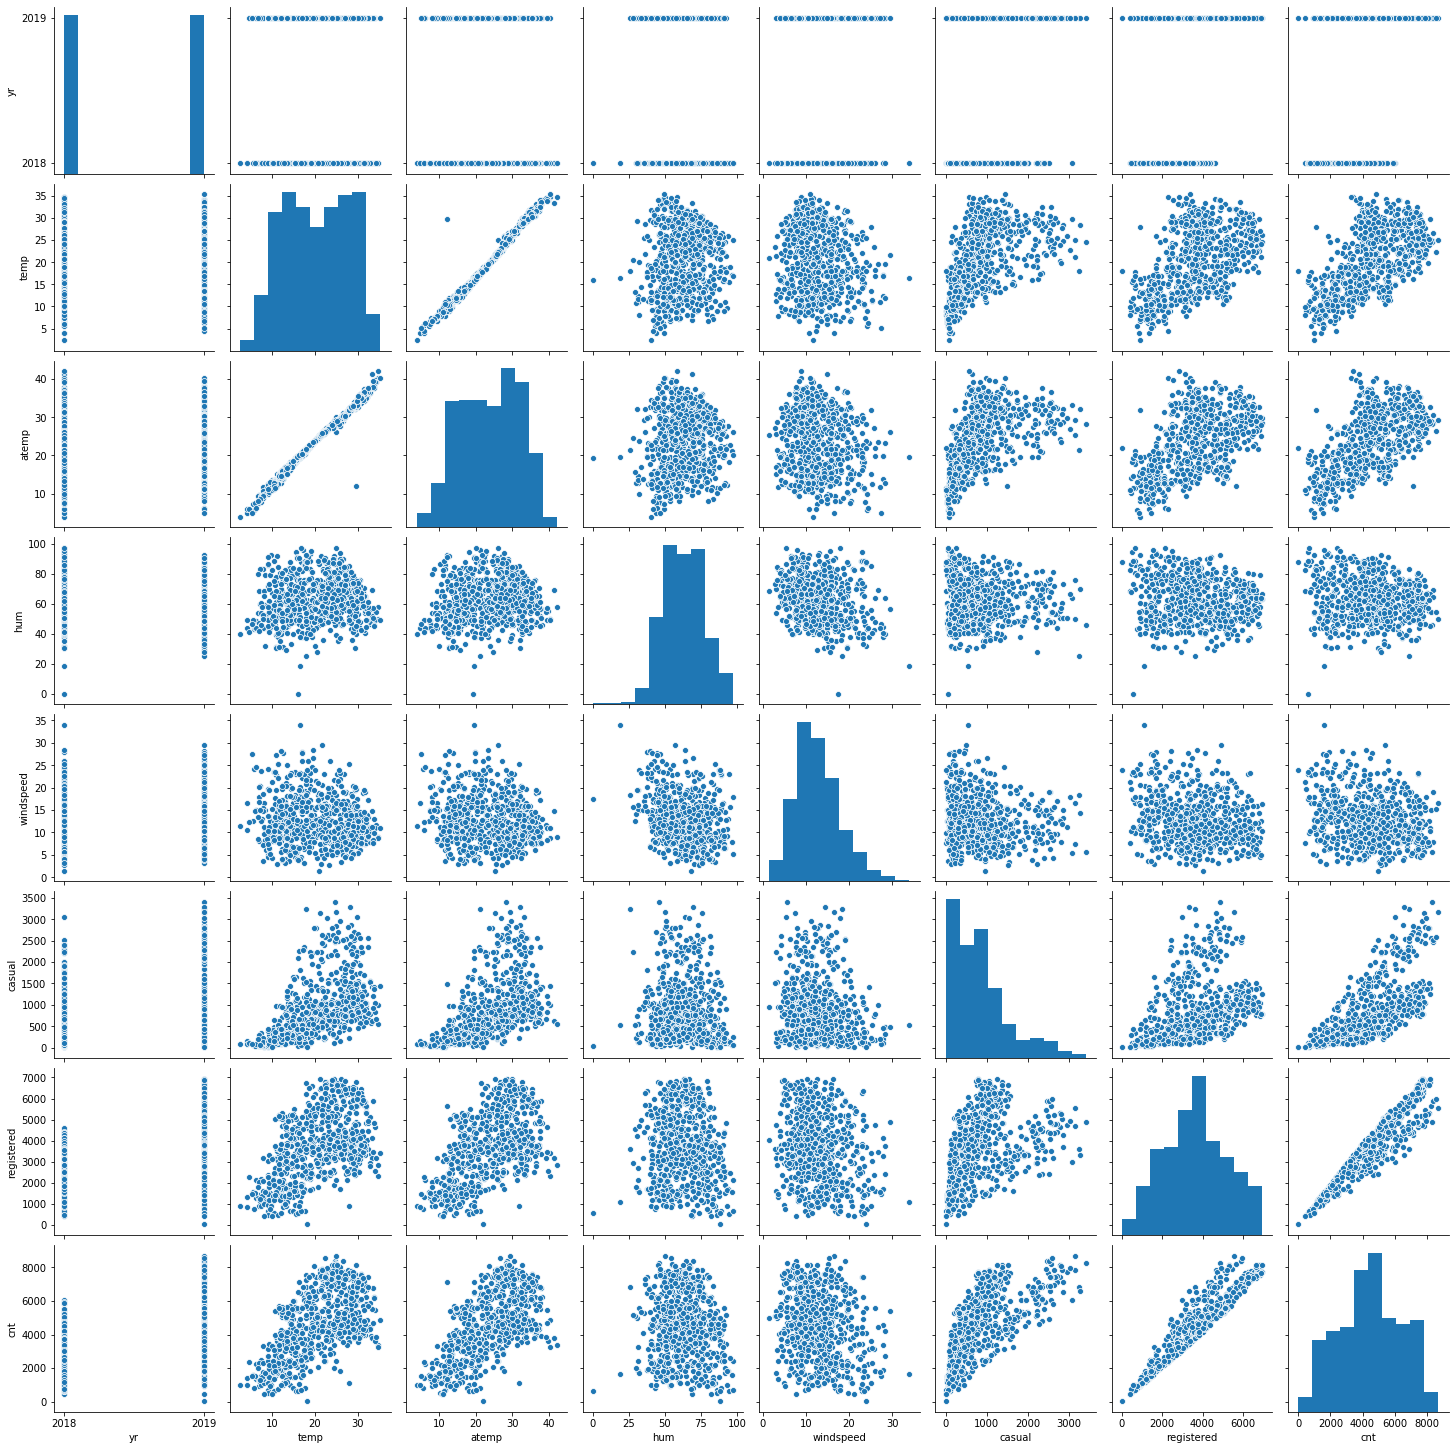

In [15]:
sns.pairplot(df.loc[:,df.columns!='instant'])
plt.show()

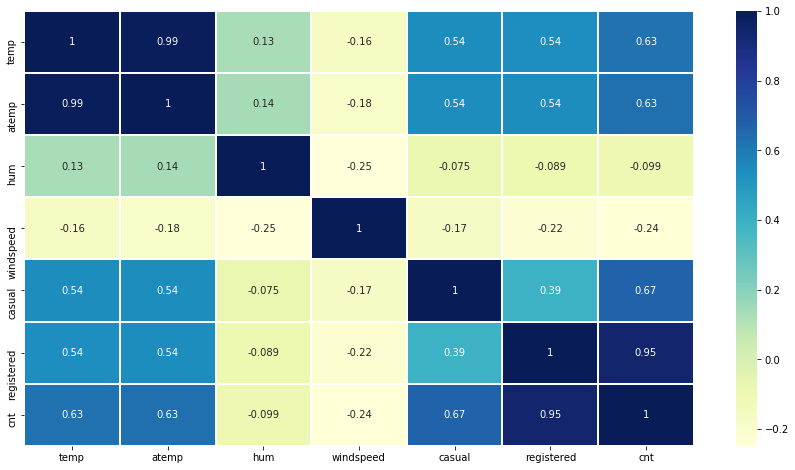

In [16]:
#correlation check for different numeric variables
plt.figure(figsize=(15,8))
sns.heatmap(df.loc[:,df.columns!='instant'].corr(),annot = True, cmap="YlGnBu",linewidth =1)
plt.show()

Let's plot boxplots for all the categorical variables for different values of `cnt`.

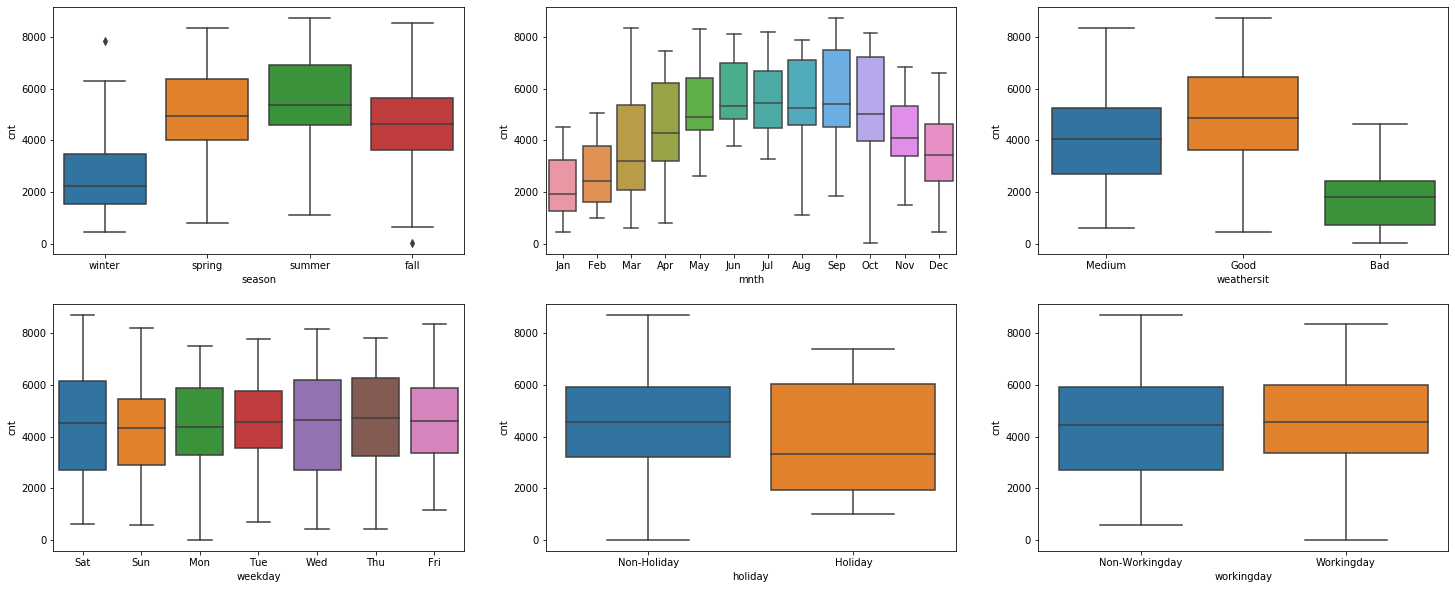

In [17]:
plt.figure(figsize=(25, 10))
plt.subplot(2,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = df)
plt.subplot(2,3,2)
sns.boxplot(x = 'mnth', y = 'cnt', data = df)
plt.subplot(2,3,3)
sns.boxplot(x = 'weathersit', y = 'cnt', data = df)
plt.subplot(2,3,4)
sns.boxplot(x = 'weekday', y = 'cnt', data = df)
plt.subplot(2,3,5)
sns.boxplot(x = 'holiday', y = 'cnt', data = df)
plt.subplot(2,3,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = df)
plt.show()

From the above two plots, we see multiple relationships. Let's go through each columns one by one and perform exploratory data analysis.

### 1. dteday:

In [18]:
df.dteday.describe()

count            730
unique           730
top       26-04-2018
freq               1
Name: dteday, dtype: object

We need to convert this column into date time format for easy analysis.

In [19]:
df['dteday']=pd.to_datetime(df.dteday,format='%d-%m-%Y')

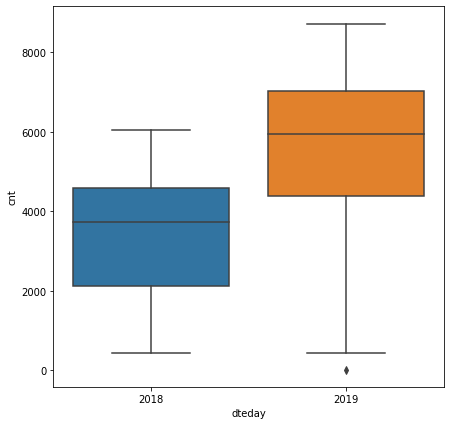

In [20]:
plt.figure(figsize=(7,7))
sns.boxplot(x=df.dteday.dt.year,y=df.cnt)
plt.show()

BoomBikes is a new startup at its initial stage. Since these bike-sharing systems are slowly gaining popularity, the demand for these bikes has increased from the year 2018 to 2019. The same is depicted by the above boxplot. <br>

We are going to build a linear model based on the above dataset. As we know that linear model can only interploate and not extrapolate, it would be wrong to use **year** column to predict demand for the **same market place** for the future year say 2020 and beyond. As the popularity of BoomBikes might increase or decrease in future. <br>

However when we explore the new market place and assume that in the new market place, the popularity of BoomBikes starts increasing at the same pace as for the place for which the data is provided, we can use **year** as one of the feature, **but only for the first two years.** For the same, we should keep **year** column as one of the predictor, provided subsequent statistical analysis allows to keep it. BoomBikes can use **year** column to input (in prepared model) the no. of years since they have established their business in the new market place and hence make prediction based on the same.

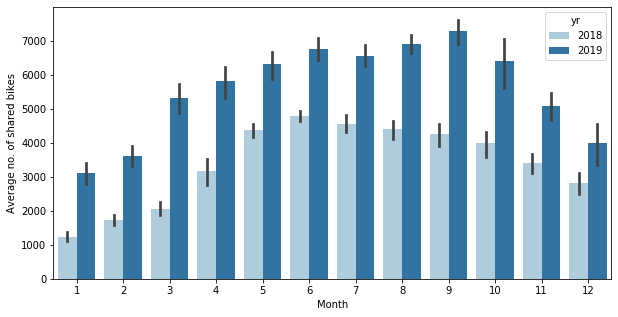

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(df['dteday'].dt.month,'cnt',data=df, hue='yr',palette='Paired')
plt.xlabel('Month')
plt.ylabel('Average no. of shared bikes')
plt.show()

From the above plots we note that for both the years, demand of shared bikes has swelled during the middle of the year. The same depicts seasonality. Spring & Summer seasons have consistently high demand of shared bikes. 

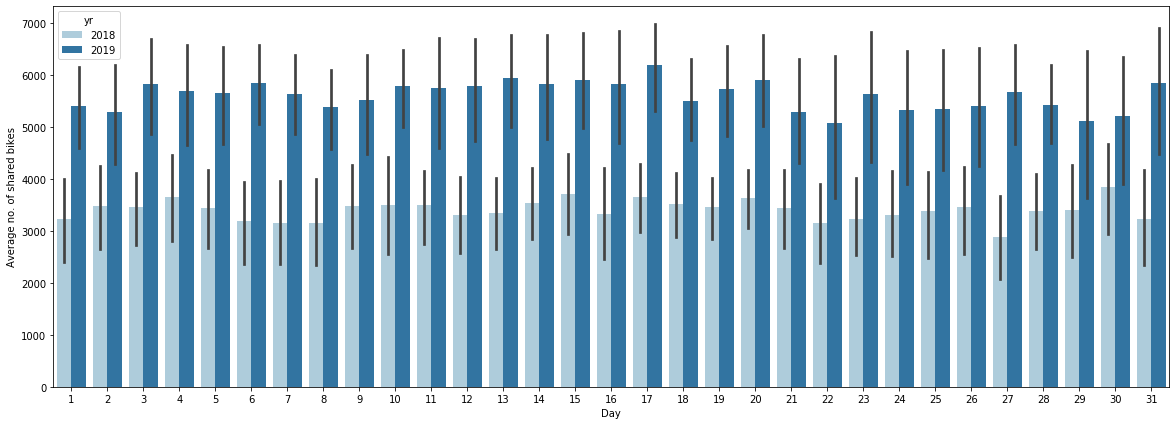

In [22]:
plt.figure(figsize=(20,7))
sns.barplot(df['dteday'].dt.day,'cnt',data=df, hue='yr',palette='Paired')
plt.xlabel('Day')
plt.ylabel('Average no. of shared bikes')
plt.show()

From the above plots, we do not see any particular pattern in no. of shared bikes in different days of months.

Since only year and month are showing patterns and the same are already present in our dataset in terms of seperate columns, we can go ahead and drop this column due to redundancy. 

### 2. season:

Let's check the season wise bike demand in different years.

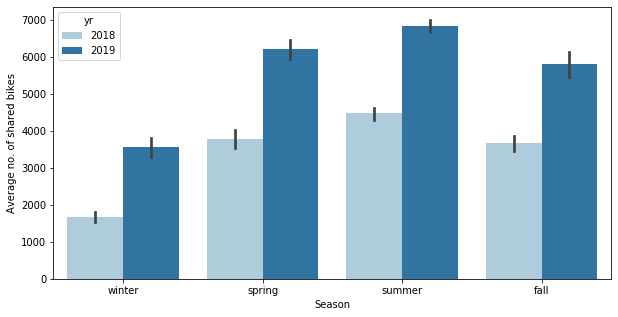

In [23]:
plt.figure(figsize=(10,5))
sns.barplot(df['season'],'cnt',data=df, hue='yr',palette='Paired')
plt.xlabel('Season')
plt.ylabel('Average no. of shared bikes')
plt.show()

As obtained from `dteday` column, we got that the demand for shared bikes is higher during the season of spring and summer for both the years. The demand is very low in winter and medium low in fall season.

### 3. Holiday:

In [24]:
#crosstable for avg. no. of shared bikes during Holidays and Non-Holidays
pd.crosstab(index=df.yr,columns=df.holiday,values=df.cnt,aggfunc='mean')   

holiday,Holiday,Non-Holiday
yr,,
2018,3002.200000,3417.129577
2019,4401.181818,5647.822034


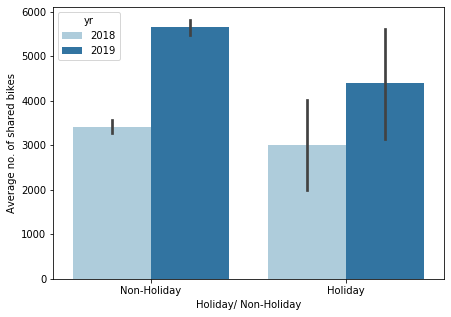

In [25]:
plt.figure(figsize=(7,5))
sns.barplot(df['holiday'],'cnt',data=df, hue='yr',palette='Paired')
plt.xlabel('Holiday/ Non-Holiday')
plt.ylabel('Average no. of shared bikes')
plt.show()

From the above plot, we note that demand for shared bikes are more on **Non-Holidays** than on **Holidays**, which might suggest that people use shared bikes to do their weekly routine tasks. The difference between **Non-Holidays** & **Holidays** is not much for the year 2018 while the same is significant for the year 2019. Let's see if we can find `workingday` column as a better metric to represent the above data.

### 4. Working day:

In [26]:
#crosstable for avg. no. of shared bikes during Workingday and Non-Workingday
pd.crosstab(index=df.yr,columns=df.workingday,values=df.cnt,aggfunc='mean')

workingday,Non-Workingday,Workingday
yr,,
2018,3363.817391,3425.056000
2019,5288.189655,5760.289157


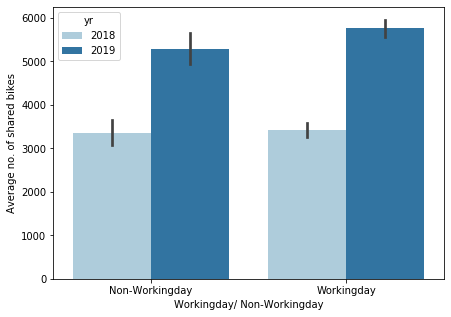

In [27]:
plt.figure(figsize=(7,5))
sns.barplot(df['workingday'],'cnt',data=df, hue='yr',palette='Paired')
plt.xlabel('Workingday/ Non-Workingday')
plt.ylabel('Average no. of shared bikes')
plt.show()

Here for both the years, there is less difference between mean shared bikes on **Workingday** and **Non-Workingday**. However since this column contains the data about both weekends and holidays, it sound a little superior over `holiday` column. But let's apply statistical methods to do feature elimination here in subsequent steps.

### 5. Weekday:

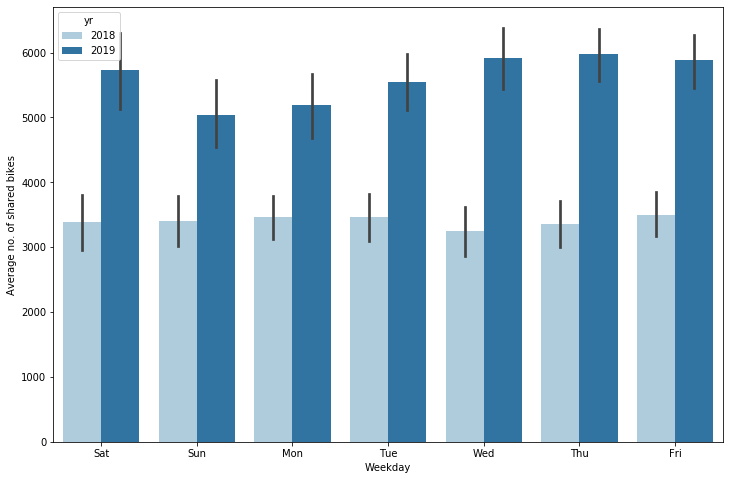

In [28]:
plt.figure(figsize=(12,8))
sns.barplot(df['weekday'],'cnt',data=df, hue='yr',palette='Paired')
plt.xlabel('Weekday')
plt.ylabel('Average no. of shared bikes')
plt.show()

We do not see any specific pattern which might indicate higher average shared bikes count in different days of week, for both the years. Let's check this column statistically in our subsequent steps.

### 6. Weather situation:

In [29]:
#check value counts of different weather conditions
df.weathersit.value_counts()

Good      463
Medium    246
Bad        21
Name: weathersit, dtype: int64

BoomBikes has mapped this column into total four categories. However customers have only shared bikes during three weather situations i.e. **Good, Medium** and **Bad**. Customers tend not to use bike when the weather situation is **worst** i.e. **Heavy Rain / Ice Pallets / Thunderstorm / Mist, Snow / Fog**, as depicted above.

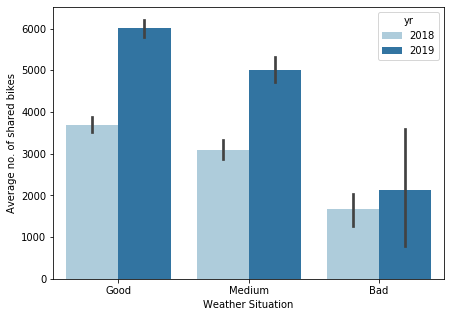

In [30]:
plt.figure(figsize=(7,5))
sns.barplot(df['weathersit'],'cnt',data=df, hue='yr',palette='Paired',order=['Good','Medium','Bad'])
plt.xlabel('Weather Situation')
plt.ylabel('Average no. of shared bikes')
plt.show()

Here we see that as the weather gets bad from good, the average no. of shared bikes decreases for both the years.

### 7. Temperature:

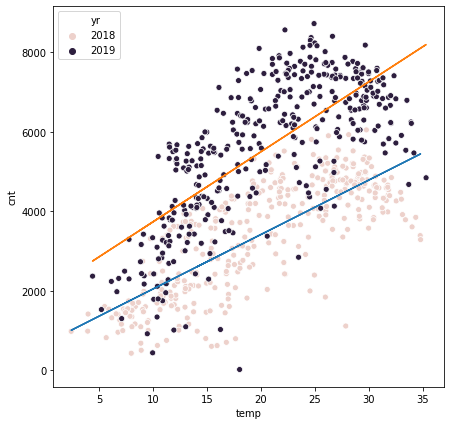

In [31]:
plt.figure(figsize=(7,7))
sns.scatterplot(df.temp,df.cnt,hue=df.yr)
#fitting regression line using numpy for yr 2018 only for visuzlization purpose
m, b = np.polyfit(df[df.yr=='2018'].temp, df[df.yr=='2018'].cnt, 1)   
plt.plot(df[df.yr=='2018'].temp, m*df[df.yr=='2018'].temp + b)
#fitting regression line using numpy for yr 2019 only for visuzlization purpose
m2, b2 = np.polyfit(df[df.yr=='2019'].temp, df[df.yr=='2019'].cnt, 1)   
plt.plot(df[df.yr=='2019'].temp, m2*df[df.yr=='2019'].temp + b2)
plt.show()

From the above, we note that both the years have positive correlations between temperature and shared bikes count.

### 8. Temperature feel:

As per this link https://blog.metoffice.gov.uk/2012/02/15/what-is-feels-like-temperature/#:~:text=Our%20'feels%20like'%20temperature%20takes,the%20measured%20temperature%20would%20indicate, unlike atmosphetic temperature, **feels like temperature**  takes into account wind speeds and humidity to assess how the human body actually feels temperature. Let's checkout it's relationship with shared bikes count.

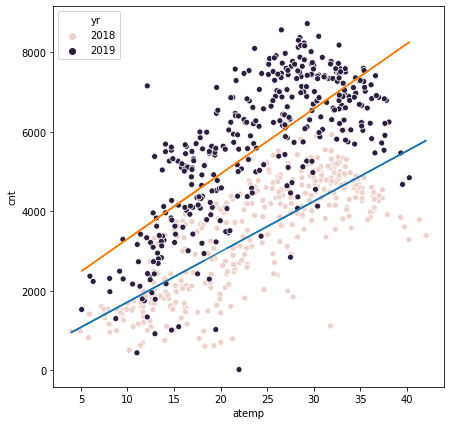

In [32]:
plt.figure(figsize=(7,7))
sns.scatterplot(df.atemp,df.cnt,hue=df.yr)
m, b = np.polyfit(df[df.yr=='2018'].atemp, df[df.yr=='2018'].cnt, 1)   #fitting regression line using numpy for yr 2018
plt.plot(df[df.yr=='2018'].atemp, m*df[df.yr=='2018'].atemp + b)
m2, b2 = np.polyfit(df[df.yr=='2019'].atemp, df[df.yr=='2019'].cnt, 1)   #fitting regression line using numpy for yr 2019
plt.plot(df[df.yr=='2019'].atemp, m2*df[df.yr=='2019'].atemp + b2)
plt.show()

Like `temp` column, `atemp` column also seems highly correlated with `cnt` column. Let's checkout the corresponding correlation values with `cnt` column to get the better idea.

In [33]:
print('Correlation between temperature feel and shared bikes counts is: ',round(np.corrcoef(df.atemp,df.temp)[0,1]*100,2))
print('Correlation between temperature and shared bikes counts is: ',round(np.corrcoef(df.temp,df.temp)[0,1]*100,2))

Correlation between temperature feel and shared bikes counts is:  99.17
Correlation between temperature and shared bikes counts is:  100.0


`temp` & `cnt` columns have comparatively higher correlation than `atemp` and `cnt` columns. But `atemp` column gives idea about wind speeds and humidity  as well which might be pivotal. Hence further statistical analysis is required to check which variable is superior.

### 9. Humidity:

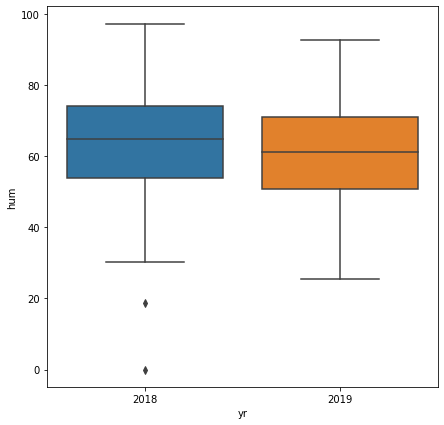

In [34]:
plt.figure(figsize=(7,7))
sns.boxplot(x=df.yr,y=df.hum)
plt.show()

Median humidity has been less in the year 2019 as compared to the year 2018. Let's see how humidity affects customer's bike sharing tendency. To do the same, let's categorize this column for better visualization.

In [35]:
df.hum.describe()

count    730.000000
mean      62.765175
std       14.237589
min        0.000000
25%       52.000000
50%       62.625000
75%       72.989575
max       97.250000
Name: hum, dtype: float64

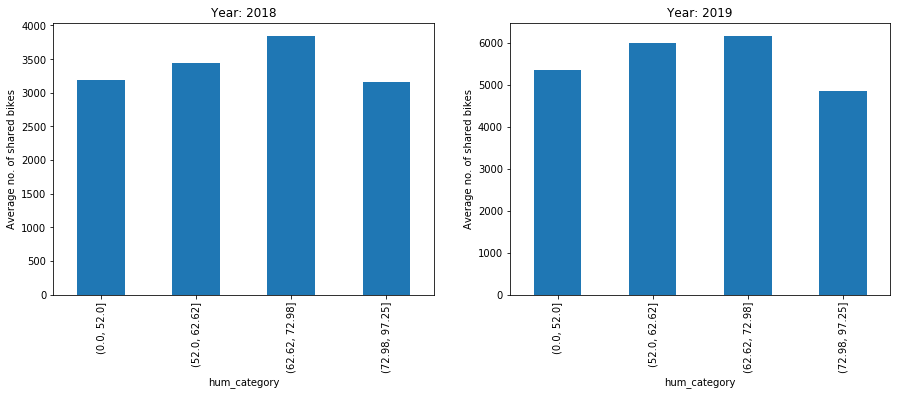

In [36]:
df['hum_category']=pd.cut(df.hum,[0,52,62.62,72.98,97.25])

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
df[df.yr=='2018'].groupby('hum_category').cnt.mean().plot.bar()
plt.title('Year: 2018')
plt.ylabel('Average no. of shared bikes')

plt.subplot(1,2,2)
df[df.yr=='2019'].groupby('hum_category').cnt.mean().plot.bar()
plt.title('Year: 2019')
plt.ylabel('Average no. of shared bikes')

plt.show()

People tend to share bikes more when the humidity level is between **52 and 73**, during both the years. But the relation is not so strong. <br><br>
Let's drop `hum_category` as it has only been crearted by us for data visialization purpose.

In [37]:
df=df.drop('hum_category',axis=1)

### 10. Windspeed:

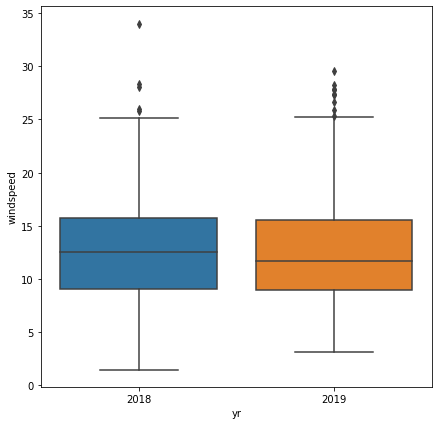

In [38]:
plt.figure(figsize=(7,7))
sns.boxplot(x=df.yr,y=df.windspeed)
plt.show()

Median windspeed has been slightly less in the year 2019 as compared to the year 2018. Let's see how this factor affects customer's bike sharing tendency. To do the same, let's categorize this column for better visualization.

In [39]:
df.windspeed.describe()

count    730.000000
mean      12.763620
std        5.195841
min        1.500244
25%        9.041650
50%       12.125325
75%       15.625589
max       34.000021
Name: windspeed, dtype: float64

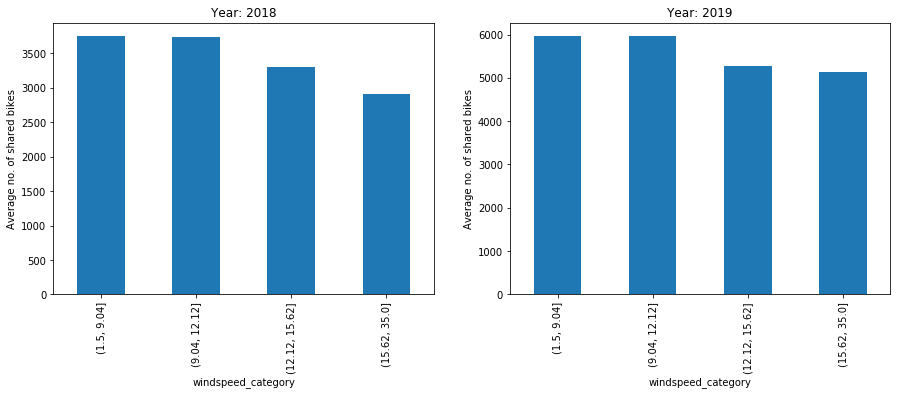

In [40]:
df['windspeed_category']=pd.cut(df.windspeed,[1.50,9.04,12.12,15.62,35.00])

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df[df.yr=='2018'].groupby('windspeed_category').cnt.mean().plot.bar()
plt.title('Year: 2018')
plt.ylabel('Average no. of shared bikes')
plt.subplot(1,2,2)
df[df.yr=='2019'].groupby('windspeed_category').cnt.mean().plot.bar()
plt.title('Year: 2019')
plt.ylabel('Average no. of shared bikes')
plt.show()

From the above we know that as windspeed is increasing fewer people tend to share bikes, during both the years. Hence higher windspeed is affecting negatively on bike sharing business.<br><br>
Let's drop `windspeed_category` as it has only been crearted by us for data visialization purpose.

In [41]:
df=df.drop('windspeed_category',axis=1)

### 11. casual,	registered & cnt:

As per data dictionary `casual + registered = cnt`. So let's verify the same.

In [42]:
(df['casual']+df['registered']!=df['cnt']).sum()             #check for data anomaly

0

The relation is **verified**. Let's check the distribution of casual and registered user counts for both the years.

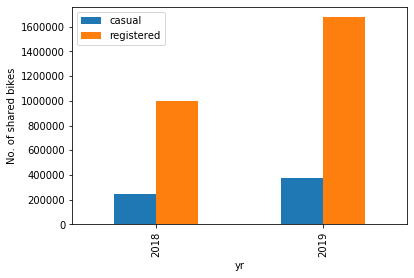

In [43]:
df.groupby('yr')['casual','registered'].sum().plot.bar()
plt.ylabel('No. of shared bikes')
plt.show()

From the above, we know that majority of the users have been **registered** users while few are **casual** users of shared bikes, during both the years.  The relationship `casual + registered = cnt` has been verified. Further, we would not have these (all three columns) data available while exploring the new market place. Hence we can certainly drop `casual` & `registered` columns and make `cnt` column as our target variable.

## Step 3: Data Preparation:

So now let's prepare the data for our linear model. We know that our model only takes numeric data, so we need to convert our data accordingly.

In [44]:
#check head
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2018-01-01,winter,2018,Jan,Non-Holiday,Sat,Non-Workingday,Medium,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-01-02,winter,2018,Jan,Non-Holiday,Sun,Non-Workingday,Medium,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-01-03,winter,2018,Jan,Non-Holiday,Mon,Workingday,Good,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-01-04,winter,2018,Jan,Non-Holiday,Tue,Workingday,Good,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-01-05,winter,2018,Jan,Non-Holiday,Wed,Workingday,Good,9.305237,11.46350,43.6957,12.522300,82,1518,1600


From our analysis in step 2 above, we can drop the following columns intuitively:
1. `instant`: We can drop this column since it cleary does not help in bike demand prediction.
2. `dteday`: This column is redundant since we already have *yr* and *mnth* columns and *date* is not showing any specific patter for bike counts.
3. `casual`: We can drop this column since we are going to use *cnt* as our terget variable and we know that *casual+registered=cnt*.
4. `registered`: We can drop this column since we are going to use *cnt* as our terget variable and we know that *casual+registered=cnt*.

In [45]:
#dropping columns based on above

df=df.drop(['instant','dteday','casual','registered'],axis=1)

In [46]:
#check the remaining columns in df
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,winter,2018,Jan,Non-Holiday,Sat,Non-Workingday,Medium,14.110847,18.18125,80.5833,10.749882,985
1,winter,2018,Jan,Non-Holiday,Sun,Non-Workingday,Medium,14.902598,17.68695,69.6087,16.652113,801
2,winter,2018,Jan,Non-Holiday,Mon,Workingday,Good,8.050924,9.47025,43.7273,16.636703,1349
3,winter,2018,Jan,Non-Holiday,Tue,Workingday,Good,8.200000,10.60610,59.0435,10.739832,1562
4,winter,2018,Jan,Non-Holiday,Wed,Workingday,Good,9.305237,11.46350,43.6957,12.522300,1600


- We need to convert `season`, `mnth`, `holiday`, `weekday`, `workingday` & `weathersit` categorical columns to dummy variables. 
- Regarding `yr` column, it is better to convert this column into the no. of years completed since BoomBikes has been operating in this particular area as the popularity of BookBikes is increasing year by year. So we can not use this column for future years in the same marke place and when we use this model into new market place for first 2 years, we assume that popularity of BoomBikes will increase at the same yearly pace.
- We would use all the P columns to represent a categorical column with P different categories, if no. of categories are more than two in categorical feature. Let statistical technique to decide which column to drop in those variables.

In [47]:
#get new column named 'yr_since_start' as just discussed
df['yr_since_start']=df.yr.apply(lambda x:0 if x=='2018' else 1)

In [48]:
#sanitiy check for yr_since_start column
df.yr_since_start.value_counts()

1    365
0    365
Name: yr_since_start, dtype: int64

In [49]:
season_dummies=pd.get_dummies(df.season,drop_first=False)   #more than 2 cagories
mnth_dummies=pd.get_dummies(df.mnth,drop_first=False)      #more than 2 categories
holiday_dummies=pd.get_dummies(df.holiday,drop_first=True)     #exactly 2 categories
weekday_dummies=pd.get_dummies(df.weekday,drop_first=False)    #more than 2 categories
workingday_dummies=pd.get_dummies(df.workingday,drop_first=True)     #exactly 2 categories
weathersit_dummies=pd.get_dummies(df.weathersit,drop_first=False)    #more than 2 categories

In [50]:
#concat the df with dummy variables
df=pd.concat([df, season_dummies, mnth_dummies, holiday_dummies, 
              weekday_dummies, workingday_dummies, weathersit_dummies], axis = 1)

In [51]:
#drop the categorical columns
df=df.drop(['season','yr','mnth','holiday','weekday','workingday','weathersit'],axis=1)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp            730 non-null    float64
 1   atemp           730 non-null    float64
 2   hum             730 non-null    float64
 3   windspeed       730 non-null    float64
 4   cnt             730 non-null    int64  
 5   yr_since_start  730 non-null    int64  
 6   fall            730 non-null    uint8  
 7   spring          730 non-null    uint8  
 8   summer          730 non-null    uint8  
 9   winter          730 non-null    uint8  
 10  Apr             730 non-null    uint8  
 11  Aug             730 non-null    uint8  
 12  Dec             730 non-null    uint8  
 13  Feb             730 non-null    uint8  
 14  Jan             730 non-null    uint8  
 15  Jul             730 non-null    uint8  
 16  Jun             730 non-null    uint8  
 17  Mar             730 non-null    uin

Now we have successfully converted all the categorical columns to dummy variables. As a result, we have all the columns in our df as numeric type.

## Step 4: Splitting the Data into Training and Testing Sets

Now let's split the data into train-test for  regression model.

In [53]:
np.random.seed(0)         # We specify this so that the train and test data set always have the same rows, respectively
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)   #splitting into 70%-30%

### Rescaling the Features 

We have some columns in 1s, some in 10s and some in 1000s. Hence it is important for us to scale them so that linear regression model converge faster and coefficient of features becomes comparable and non-dominant. Let's use Min-Max scaling for the same.<br><br>
*Ideally we should be using two seperate scaler object to fit using X_train and y_train since in the new market place we would only have X_new and we would have to predict y_new. At that time also we would have to transform X_new using our old scaler and scaler object does not take one column less due to absence of y_new, if both are fit together. Neverthless, for now let's just fit both X_train and y_train together.*<br>

In [54]:
scaler = MinMaxScaler()

In [55]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['temp', 'atemp', 'hum', 'windspeed','cnt','yr_since_start'] 

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

Note just above that we have scaled `yr_since_start` column since we would get this column data as no. of years since BoomBikes start operating.

In [56]:
df_train.describe()

,temp,atemp,hum,windspeed,cnt,yr_since_start,fall,spring,summer,winter,...,Mon,Sat,Sun,Thu,Tue,Wed,Workingday,Bad,Good,Medium
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.537262,0.512989,0.650369,0.320768,0.513620,0.507843,0.24902,0.245098,0.262745,0.243137,...,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824,0.676471,0.029412,0.627451,0.343137
std,0.225844,0.212385,0.145882,0.169797,0.224593,0.500429,0.43287,0.430568,0.440557,0.429398,...,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870,0.468282,0.169124,0.483958,0.475223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.540519,0.526811,0.653714,0.296763,0.518638,1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,0.735215,0.688457,0.754830,0.414447,0.684710,1.000000,0.00000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Dividing the train data into X and Y sets for the model building

In [57]:
y_train = df_train.pop('cnt')
X_train = df_train

## Step 5: Building a linear model

Our dataset has more than 15 independent variables and 1 dependent variable. Let's use RFE first to get the top 15 significate features and then do manual feature filtering with the help of p-values and VIF values of predictor variables.

*RFE: It is termed as Recursive feature elimination provided by SciKitLearn package.*

In [58]:
# Running RFE with the output number of the variable set to 15
lm = LinearRegression()
rfe = RFE(lm, 15)             
rfe = rfe.fit(X_train, y_train)

In [59]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('temp', True, 1),
 ('atemp', False, 6),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('yr_since_start', True, 1),
 ('fall', True, 1),
 ('spring', False, 12),
 ('summer', True, 1),
 ('winter', True, 1),
 ('Apr', False, 16),
 ('Aug', False, 8),
 ('Dec', False, 4),
 ('Feb', False, 5),
 ('Jan', False, 2),
 ('Jul', True, 1),
 ('Jun', False, 17),
 ('Mar', False, 15),
 ('May', False, 7),
 ('Nov', False, 3),
 ('Oct', False, 14),
 ('Sep', True, 1),
 ('Non-Holiday', True, 1),
 ('Fri', False, 13),
 ('Mon', False, 10),
 ('Sat', True, 1),
 ('Sun', False, 9),
 ('Thu', False, 18),
 ('Tue', False, 11),
 ('Wed', False, 19),
 ('Workingday', True, 1),
 ('Bad', True, 1),
 ('Good', True, 1),
 ('Medium', True, 1)]

In [60]:
col = X_train.columns[rfe.support_]
print('Columns whom RFE supports are: ', X_train.columns[rfe.support_])
print('Columns whom RFE doesnt support are: ', X_train.columns[~rfe.support_])

Columns whom RFE supports are:  Index(['temp', 'hum', 'windspeed', 'yr_since_start', 'fall', 'summer',
       'winter', 'Jul', 'Sep', 'Non-Holiday', 'Sat', 'Workingday', 'Bad',
       'Good', 'Medium'],
      dtype='object')
Columns whom RFE doesnt support are:  Index(['atemp', 'spring', 'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jun', 'Mar',
       'May', 'Nov', 'Oct', 'Fri', 'Mon', 'Sun', 'Thu', 'Tue', 'Wed'],
      dtype='object')


We are left with above 15 columns whom RFE supports. Let's build model using statsmodel, for the detailed statistical analysis and manual feature elimination.

In [61]:
# function to find VIF of different features

def find_vif(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

### LR Model 1:

In [62]:
# Creating X_test dataframe with RFE selected 15 variables
X_train_rfe = X_train[col]
X_train_rfe = sm.add_constant(X_train_rfe)
lm_1 = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [63]:
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.3
Date:                Sat, 28 Nov 2020   Prob (F-statistic):          1.13e-191
Time:                        13:00:41   Log-Likelihood:                 517.87
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     495   BIC:                            -942.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0984      0.032      3.

Looking at the p-values, all of them are less than 5%. Let's checkout the VIF as well.

In [64]:
#find VIF of different features of X_train_rfe
find_vif(X_train_rfe)

,Features,VIF
13,Bad,inf
14,Good,inf
15,Medium,inf
1,temp,3.62
6,summer,2.74
7,winter,2.55
2,hum,1.91
5,fall,1.88
12,Workingday,1.88
11,Sat,1.78


VIF of `Bad`, `Good` and `Medium` are infinite due to obvious reason that any two of the three can 100% explain the third one. Let's start by dropping `Medium` as it seems the least impactful, based on our univariate analysis and it's coefficient has least magnitude among the three.

### LR Model 2:

In [65]:
X_train_lm2=X_train_rfe.drop('Medium',axis=1)

In [66]:
X_train_lm2 = sm.add_constant(X_train_lm2)

In [67]:
lm_2 = sm.OLS(y_train,X_train_lm2).fit()   # Running the linear model

In [68]:
print(lm_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.3
Date:                Sat, 28 Nov 2020   Prob (F-statistic):          1.13e-191
Time:                        13:00:41   Log-Likelihood:                 517.87
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     495   BIC:                            -942.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1747      0.043      4.

In [69]:
#check VIF values
find_vif(X_train_lm2)

,Features,VIF
0,const,118.18
1,temp,3.62
6,summer,2.74
7,winter,2.55
2,hum,1.91
5,fall,1.88
12,Workingday,1.88
11,Sat,1.78
14,Good,1.63
8,Jul,1.49


All the p-values of variables seems less than 5% and all the VIF values are less than 5 now. Let's check the coefficient of diferent predictors and check their strength.

In [70]:
lm_2.params.apply(lambda x:-x if x<0 else x).sort_values(ascending=False)   #magnitude of different coefficients

temp              0.527819
yr_since_start    0.229738
Bad               0.188485
windspeed         0.180601
const             0.174711
hum               0.159467
winter            0.108047
Sep               0.081773
Non-Holiday       0.059434
Good              0.057847
Jul               0.054881
Sat               0.053203
summer            0.052613
fall              0.047681
Workingday        0.043216
dtype: float64

From above, let's remove `Non-Holiday` being higest p-value for our futher model.

### LR Model 3:

In [71]:
X_train_lm3=X_train_lm2.drop('Non-Holiday',axis=1)

In [72]:
X_train_lm3 = sm.add_constant(X_train_lm3)

In [73]:
lm_3 = sm.OLS(y_train,X_train_lm3).fit()   # Running the linear model

In [74]:
print(lm_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     209.4
Date:                Sat, 28 Nov 2020   Prob (F-statistic):          8.51e-192
Time:                        13:00:42   Log-Likelihood:                 515.37
No. Observations:                 510   AIC:                            -1003.
Df Residuals:                     496   BIC:                            -943.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2252      0.036      6.

In [75]:
find_vif(X_train_lm3)

,Features,VIF
0,const,84.41
1,temp,3.62
6,summer,2.74
7,winter,2.55
2,hum,1.91
5,fall,1.87
11,Workingday,1.65
10,Sat,1.64
13,Good,1.63
8,Jul,1.49


All the p-values of variables seems less than 5% and all the VIF values are less than 5 now. Let's check the coefficient of diferent predictors and check their strength.

In [76]:
lm_3.params.apply(lambda x:-x if x<0 else x).sort_values(ascending=False)   #magnitude of different coefficients

temp              0.527923
yr_since_start    0.229966
const             0.225209
Bad               0.187960
windspeed         0.181186
hum               0.157829
winter            0.109466
Sep               0.079694
Sat               0.062161
Good              0.057573
Jul               0.053732
summer            0.052962
Workingday        0.052059
fall              0.046375
dtype: float64

We want to make our model more simpler. Let's remove `Jul` being highest p-value.

### LR Model 4:

In [77]:
X_train_lm4=X_train_lm3.drop('Jul',axis=1)
X_train_lm4 = sm.add_constant(X_train_lm4)

In [78]:
lm_4 = sm.OLS(y_train,X_train_lm4).fit()   # Running the linear model

In [79]:
print(lm_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     222.7
Date:                Sat, 28 Nov 2020   Prob (F-statistic):          4.23e-191
Time:                        13:00:43   Log-Likelihood:                 510.90
No. Observations:                 510   AIC:                            -995.8
Df Residuals:                     497   BIC:                            -940.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2281      0.037      6.

In [80]:
find_vif(X_train_lm4)

,Features,VIF
0,const,84.35
1,temp,3.53
7,winter,2.52
6,summer,2.39
2,hum,1.90
5,fall,1.86
10,Workingday,1.65
9,Sat,1.64
12,Good,1.63
3,windspeed,1.20


All the p-values of variables are less than 5% and all the VIF values are less than 5. We still have 12 predictors, but we need a more simpler model to avoid any overfitting.

In [81]:
lm_4.params.apply(lambda x:-x if x<0 else x).sort_values(ascending=False)   #magnitude of different coefficients

temp              0.512675
yr_since_start    0.230700
const             0.228086
Bad               0.191206
windspeed         0.179875
hum               0.150823
winter            0.113489
Sep               0.094023
summer            0.068717
Sat               0.062701
Good              0.057310
Workingday        0.053223
fall              0.043207
dtype: float64

We can remove `fall` being highest p-value. Besides `winter` and `summer` are stronger indicator of shared bike count as per our univariate analysis.

### LR Model 5:

In [82]:
X_train_lm5=X_train_lm4.drop('fall',axis=1)
X_train_lm5=sm.add_constant(X_train_lm5)

In [83]:
lm_5 = sm.OLS(y_train,X_train_lm5).fit()   # Running the linear model
print(lm_5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     236.7
Date:                Sat, 28 Nov 2020   Prob (F-statistic):          9.05e-190
Time:                        13:00:43   Log-Likelihood:                 504.91
No. Observations:                 510   AIC:                            -985.8
Df Residuals:                     498   BIC:                            -935.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2601      0.036      7.

In [84]:
find_vif(X_train_lm5)

,Features,VIF
0,const,78.89
1,temp,3.01
5,summer,2.28
2,hum,1.86
6,winter,1.67
9,Workingday,1.65
8,Sat,1.64
11,Good,1.61
3,windspeed,1.18
7,Sep,1.18


All the p-values of variables are less than 5% and all the VIF values are less than 5. We have 11 predictors now, but should again try and drop feature to avoid any overfitting and get the simplest possible model.

In [85]:
lm_5.params.apply(lambda x:-x if x<0 else x).sort_values(ascending=False)   #magnitude of different coefficients

temp              0.468845
const             0.260113
yr_since_start    0.231953
windspeed         0.188260
Bad               0.185128
winter            0.142998
hum               0.131287
Sep               0.096289
summer            0.079033
Sat               0.061961
Good              0.061464
Workingday        0.051245
dtype: float64

Let's remove `hum` column due to its low magniture of t-value.

### LR Model 6:

In [86]:
X_train_lm6=X_train_lm5.drop('hum',axis=1)
X_train_lm6=sm.add_constant(X_train_lm6)

In [87]:
lm_6 = sm.OLS(y_train,X_train_lm6).fit()   # Running the linear model
print(lm_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     253.5
Date:                Sat, 28 Nov 2020   Prob (F-statistic):          2.18e-188
Time:                        13:00:44   Log-Likelihood:                 498.77
No. Observations:                 510   AIC:                            -975.5
Df Residuals:                     499   BIC:                            -929.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1592      0.021      7.

In [88]:
find_vif(X_train_lm6)

,Features,VIF
0,const,27.14
1,temp,2.88
4,summer,2.21
5,winter,1.67
8,Workingday,1.64
7,Sat,1.63
6,Sep,1.16
10,Good,1.08
2,windspeed,1.07
9,Bad,1.07


In [89]:
lm_6.params.apply(lambda x:-x if x<0 else x).sort_values(ascending=False)   #magnitude of different coefficients

temp              0.446558
yr_since_start    0.234983
Bad               0.201450
windspeed         0.160400
const             0.159155
winter            0.141200
Sep               0.089836
Good              0.082562
summer            0.071029
Sat               0.065809
Workingday        0.053751
dtype: float64

All the p-values of variables are less than 5% and all the VIF values are less than 5. We have 10 predictors now, which seem reasonably simple. We have reasonably good values of **R-squared** & **Adj. R-squared** compared to previous models with high no. of features. Further, we have **Prob (F-statistic)** value statistically significant as compared to restricted model. So let's go ahead with the analysis of this last built model.

## Step 6: Residual Analysis of the train data

So, now to check if the error terms are also normally distributed which is one of the assumption of regression model, let us plot the histogram of the error terms on training model and see what it looks like.

In [90]:
y_train_pred_lm6 = lm_6.predict(X_train_lm6)   #predicting y_train using final model

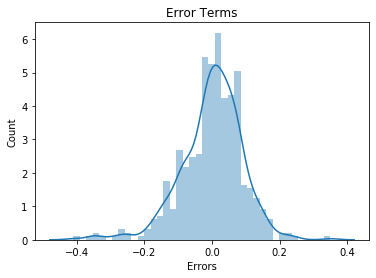

In [91]:
# Plot the histogram of the error terms

sns.distplot((y_train - y_train_pred_lm6), bins = 40)
plt.title('Error Terms')                  # Plot heading 
plt.xlabel('Errors')                         # X-label
plt.ylabel('Count')                         # Y-label
plt.show()

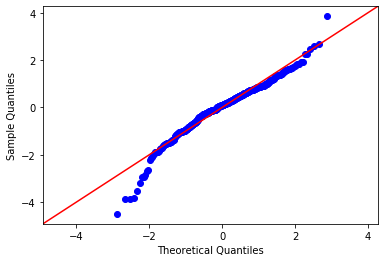

In [92]:
# plot qqplot with statsmodels 
sm.qqplot((y_train - y_train_pred_lm6),fit=True,line='45')
plt.show()

From the distribution of error plot, we note that error terms are approximately **normally distributed with mean zero**. Q-Q plot of error terms almost passes through straight line. This also indicates that error terms are normally distributed.

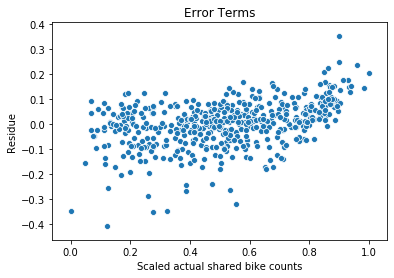

In [93]:
sns.scatterplot(x=y_train, y=(y_train - y_train_pred_lm6))
plt.title('Error Terms')                  # Plot heading 
plt.xlabel('Scaled actual shared bike counts')                         # X-label
plt.ylabel('Residue')                         # Y-label
plt.show()

- From the above we do not find any pattern for the different residual values of count on training set. Hence error terms are deemed **independent**.
- Here **variance** of error term seem almost **constant**.

Hence we can hereby declare that all the assumptions of Linear Regression is satisfied by our model no. 6 (lm_6). So let's go ahead with prediction part.

## Step 7: Making Predictions Using the Final Model

Now that we have fitted the model and checked the normality of error terms, it's time to go ahead and make predictions using the final model.

#### Applying the scaling on the test sets

In [94]:
df_test[num_vars] = scaler.transform(df_test[num_vars])   #using the already fit scaler object

In [95]:
#check train data
df_test.describe()

,temp,atemp,hum,windspeed,cnt,yr_since_start,fall,spring,summer,winter,...,Mon,Sat,Sun,Thu,Tue,Wed,Workingday,Bad,Good,Medium
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.558941,0.532991,0.638508,0.313350,0.520592,0.479452,0.232877,0.264840,0.246575,0.255708,...,0.127854,0.118721,0.146119,0.164384,0.164384,0.100457,0.698630,0.027397,0.652968,0.319635
std,0.233698,0.217888,0.148974,0.159947,0.218435,0.500722,0.423633,0.442259,0.432005,0.437258,...,0.334692,0.324202,0.354034,0.371472,0.371472,0.301297,0.459904,0.163612,0.477117,0.467403
min,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.354650,0.344751,0.527265,0.198517,0.377531,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.558691,0.549198,0.627737,0.299459,0.524275,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,0.759096,0.714132,0.743928,0.403048,0.672745,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Dividing into X_test and y_test

In [96]:
y_test = df_test.pop('cnt')
X_test = df_test

In [97]:
# Adding constant to test dataframe
X_test_lm6 = sm.add_constant(X_test)

In [98]:
#check the variables in X_train_lm6
X_train_lm6.columns

Index(['const', 'temp', 'windspeed', 'yr_since_start', 'summer', 'winter',
       'Sep', 'Sat', 'Workingday', 'Bad', 'Good'],
      dtype='object')

In [99]:
# Creating X_test_lm6 dataframe by keeping variables as per X_train_lm6

X_test_lm6 = X_test_lm6[['const', 'temp', 'windspeed', 'yr_since_start', 'summer', 'winter',
       'Sep', 'Sat', 'Workingday', 'Bad', 'Good']]

In [100]:
# Making predictions using the final model

y_pred_test_lm6 = lm_6.predict(X_test_lm6)

## Step 8: Model Evaluation

Let's now plot the graph for actual versus predicted values on test set.

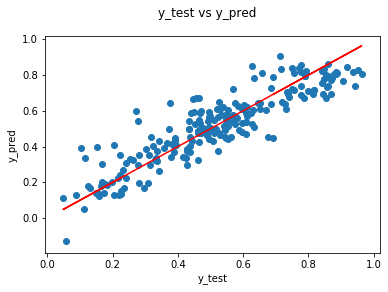

In [101]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred_test_lm6)
plt.plot(y_test,y_test,'r')                   #plotting y_test-y_test line
fig.suptitle('y_test vs y_pred')              # Plot heading 
plt.xlabel('y_test')                          # X-label
plt.ylabel('y_pred')                          # Y-label
plt.show()

In [102]:
n0=X_train_lm6.shape[0]     #no. of samples
p0=X_train_lm6.shape[1]-1     #no. of independent predictors

r2_train=r2_score(y_train, y_train_pred_lm6)
print('R square value of train data on final model is: ',r2_train)
print('R square adjusted value of train data on final model is: ',1-((1-r2_train)*(n0-1)/(n0-p0-1)))

R square value of train data on final model is:  0.8355154261193748
R square adjusted value of train data on final model is:  0.8322191420736709


In [103]:
n=X_test_lm6.shape[0]     #no. of samples
p=X_test_lm6.shape[1]-1     #no. of independent predictors

r2_test=r2_score(y_test, y_pred_test_lm6)
print('R square value of test data on final model is: ',r2_test)
print('R square adjusted value of test data on final model is: ',1-((1-r2_test)*(n-1)/(n-p-1)))

R square value of test data on final model is:  0.8038003773854856
R square adjusted value of test data on final model is:  0.7943677032213263


From the above, we do not see much difference between R sequare values on train and test data sets.

In [104]:
#check the different parameters of features
lm_6.params.sort_values()

Bad              -0.201450
windspeed        -0.160400
winter           -0.141200
summer           -0.071029
Workingday        0.053751
Sat               0.065809
Good              0.082562
Sep               0.089836
const             0.159155
yr_since_start    0.234983
temp              0.446558
dtype: float64

#### Predictors to watchout for:

Now since we have scaled all the variables within the range of 0 and 1 before training the model, we can directly compare the magnitudes of different coefficient of variables and based on the same, we can figure out the most significant variables i.e. higher the magnitude of coefficient, more important is the corresponding variable.

1. **Temperature:** Temperature is clearly the most impactful variable. The sign is positive hence higher the temperature, more people tend to use bikes.
2. **yr_since_start:** This is second most significant variable. It has positive impact on bike sharing business. The same indicates BoomBikes' business is hiking on yearly basis.
3. **Bad:** This is third most impactful variable. It also has negiative impact on bike sharing. Hence BoomBikes may reduce bike availability on days with *Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog*.